## RNN and LSTM Model Calibration 
Done by: Chamath Wijerathne, Nada Rahali, Tanjuma Haque

In [50]:
# import libraries
import kagglehub
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU

## Initial exploratory analysis

In [51]:
# load the dataset
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\anura\.cache\kagglehub\datasets\uciml\electric-power-consumption-data-set\versions\1


In [52]:
os.listdir(path)

['household_power_consumption.txt']

In [53]:
file_path = os.path.join(path, "household_power_consumption.txt")
df = pd.read_csv(file_path, sep=";", na_values="?", low_memory=False)
df.head()

Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0

In [54]:
df["DateTime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S"
)
df = df.set_index("DateTime")
df = df.drop(columns=["Date", "Time"])

In [55]:
df.head()

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
DateTime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [56]:
missing_values = df.isnull().sum()
print(missing_values)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


Some timestamps contain no measurement values at all, the dataset contains 25,979 rows with missing measurement values, corresponding to approximately 1.25% of all timestamps which matches with the dataset description. 

In [57]:
df.index.to_series().diff().value_counts().head(10)

DateTime
0 days 00:01:00    2075258
Name: count, dtype: int64

Based on the results of the code above, the datetime index shows a consistent 1-minute interval with no missing timestamps meaning we don't need to enforce frequency. Therefore, only the measurement values are missing, not the timestamps which will be addressed through linear interpolation. 

In [58]:
df = df.interpolate()
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Now that the dataset is cleaned and the missing values have been handled, we can begin exploring the time-series characteristics.
To understand the dataset better, we will:
1. Check the time range of the dataset (start and end date).

2. Compute the target variable y: y = (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3)
   
   y = the energy used by all the appliances that are not in the 3 sub-meters => unmeasured energy
   
3. Visualize the target variable y over time.
  
1. Identify visible patterns such as daily, weekly, or yearly patterns, trends, or changes in target variable y. 

In [59]:
df.index.min(), df.index.max()

(Timestamp('2006-12-16 17:24:00'), Timestamp('2010-11-26 21:02:00'))

In [60]:
df["y"] = (
    df["Global_active_power"] * 1000 / 60
    - df["Sub_metering_1"]
    - df["Sub_metering_2"]
    - df["Sub_metering_3"]
)

In [61]:
df[["y"]].head()

y
DateTime                      
2006-12-16 17:24:00  52.266667
2006-12-16 17:25:00  72.333333
2006-12-16 17:26:00  70.566667
2006-12-16 17:27:00  71.800000
2006-12-16 17:28:00  43.100000

In [62]:
df.head()

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3          y  
DateTime                                        
2006-12-16 17:24:00            17.0  52.266667  
2006-12-16 17:25:00            16.0  72.333333  
2006-12-16 17:26:00            17.0  70.566667  
2006-12-16 17:27:00            17.0  71.800000  
2006-12-16 17:28:00            17.0  43.100000

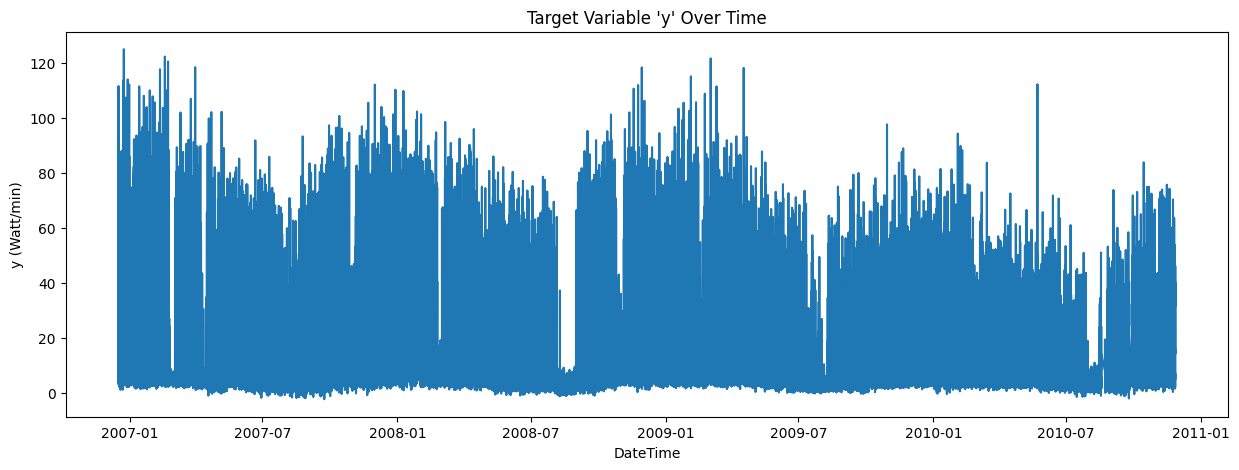

In [63]:
# visualize the target variable 'y' over time 'per minute'
plt.figure(figsize=(15,5))
plt.plot(df.index, df["y"], label="y", color="#1f77b4")
plt.xlabel("DateTime")
plt.ylabel("y (Watt/min)")
plt.title("Target Variable 'y' Over Time")
plt.show()

The minute-level plot is highly noisy, which was a bit hard to understand and explain, that is why the hourly and daily plots are visualized to better understand the seasonality shape. 

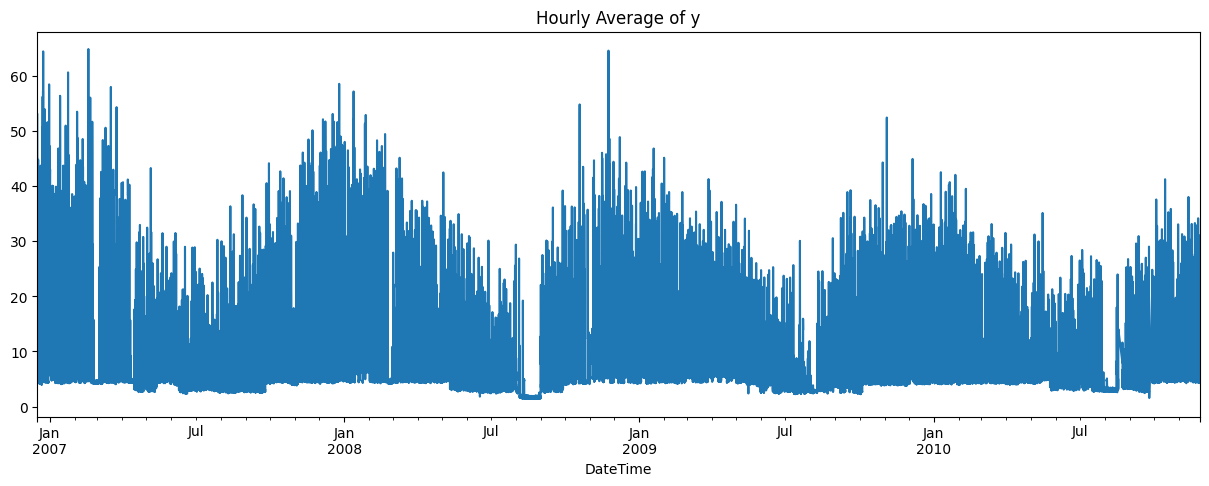

In [64]:
plt.figure(figsize=(15,5))
df["y"].resample("h").mean().plot()
plt.title("Hourly Average of y")
plt.show()

The high frequency noise in minute level data is much reduced in this hourly averaged plot. The resulting plot shows that long term seasonal structures are more apparent: we can easily see repeated yearly cycles, where energy usage peaks during the winter months and troughs during summer. Hourly averaging removes many of the individual daily fluctuations but enhances the medium-term and seasonal trends.

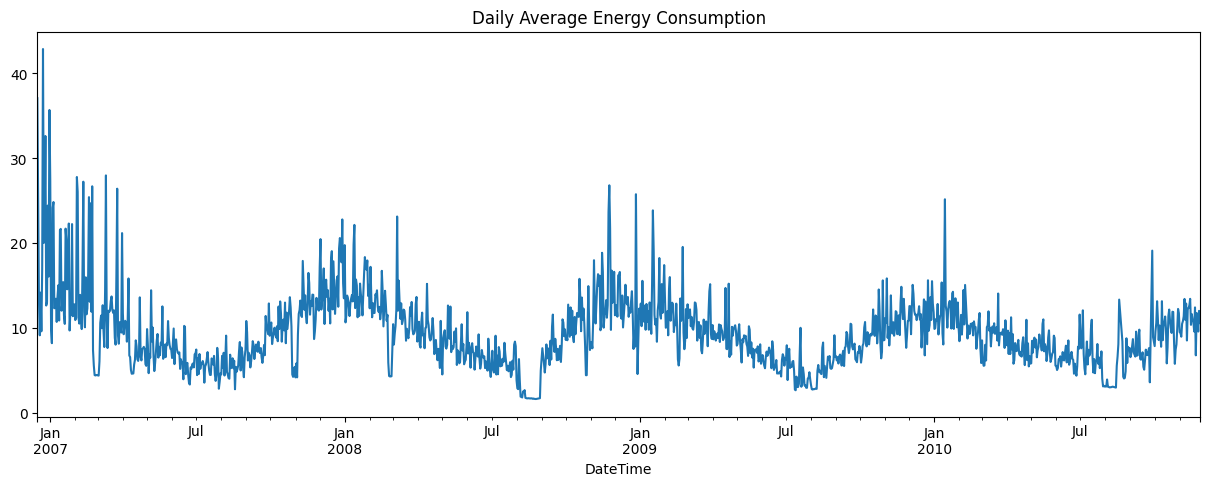

In [65]:
y_daily = df["y"].resample("D").mean()

plt.figure(figsize=(15,5))
y_daily.plot()
plt.title("Daily Average Energy Consumption")
plt.show()

Clearly, there is a strong annual seasonal pattern observed in the daily averaged energy consumption plot. Electricity consumption is highest during winter months (December-February), reaching around 20-30 Wh/minute, presumably due to increased heating demand, extended indoor lighting usages, and higher hot water consumption. From winter until mid summer, consumption decreases in a stepwise fashion, reaching a low of around 5-10 Wh/min due to lower heating demands and longer daylight hours. Past mid summer, the trend reverses, and energy consumption increases steadily into winter. This pattern repeats consistently across all observed years, confirming a strong yearly seasonality in household electricity use.

## Time-series decomposition analysis of long-term trend, seasonality, and residuals

In [66]:
df.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.090280e+00           1.236492e-01  2.408328e+02   
std           1.052628e+00           1.124194e-01  3.237763e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.100000e-01           4.800000e-02  2.389900e+02   
50%           6.140000e-01           1.000000e-01  2.410000e+02   
75%           1.528000e+00           1.940000e-01  2.428700e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
count      2.075259e+06    2.075259e+06    2.075259e+06    2.075259e+06   
mean       4.621481e+00    1.109485e+00    1.289229e+00    6.442386e+00   
std        4.424361e+00    6.115843e+00    5.786613e+00    8.415860e+00   
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00   
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00   
50%        2.751585e+00    0.000000e+00    0.000000e+00    1.000000e+00   
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01   
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01   

                  y  
count  2.075259e+06  
mean   9.330226e+00  
std    9.546528e+00  
min   -2.400000e+00  
25%    3.833333e+00  
50%    5.533333e+00  
75%    1.046667e+01  
max    1.248333e+02

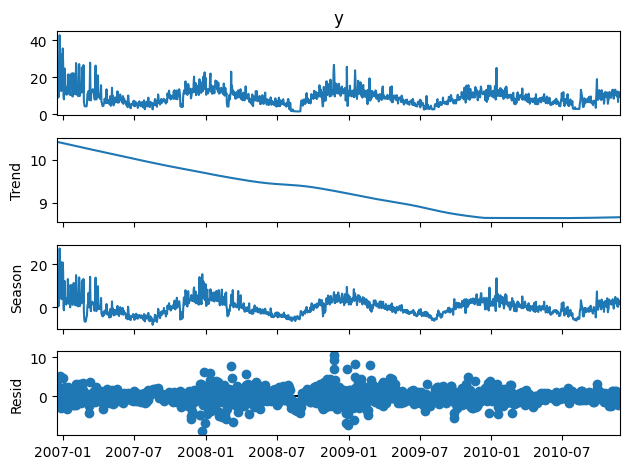

In [67]:
stl = STL(y_daily, period=365)
res = stl.fit()
res.plot()
plt.show()

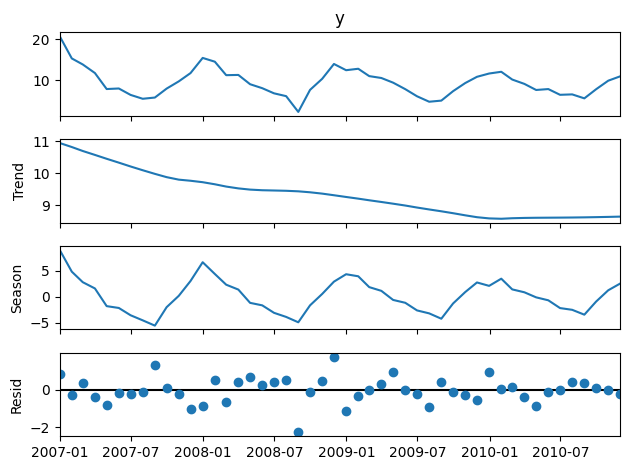

In [68]:
y_monthly = df["y"].resample("ME").mean()
stl = STL(y_monthly, period=12, seasonal=13, trend=21)
res = stl.fit()
res.plot()
plt.show()

Based on my understandings of the plots, the stl decomposition shows 3 main components: 

- Observed: the daily plot is very spiky, because energy usage differ a lot day-to-day. However, in the monthly data, it is much cleaner which is best for interpretation. 

- Trend => long-term upward: The long-term trend is lightly decreasing from ~11 to ~9 same goes for the monthly data. 

- Seasonality => repeating yearly patterns: Higher energy consumption during winter months (December–February), which means more energy. While, Lower energy usage during summer months (June–August) => less energy. 

- Residual => random noise: The residuals of the daily STL decomposition are mostly small and randomly distributed around zero, which does not show clear patterns of daily ouliers, in this case applying the robust fitting will be better to make the decomposition more robust to outliers. Compared to monthly stl, residuals looks clean no need for robust fitting. 

However, monthly decomposition shows smoother and more interpretable components, while daily decomposition is noisier and benefits from robust fitting.

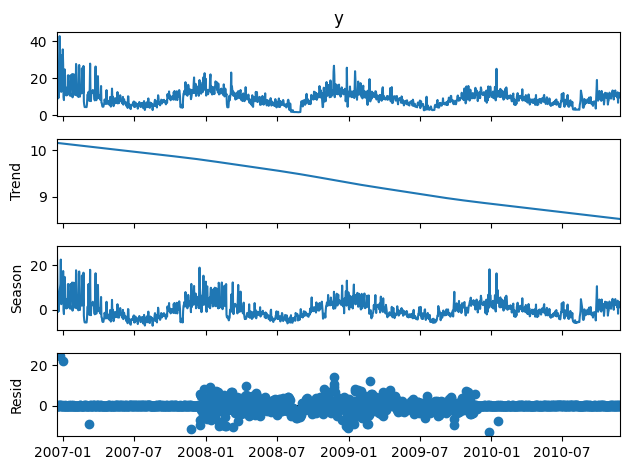

In [69]:
stl_robust = STL(y_daily, period=365, robust=True)
res_robust = stl_robust.fit()
res_robust.plot()
plt.show()

Robust fitting (robust=True) was used to prevent these outliers from distorting the trend and seasonality.The residual component appears noisy with visible outliers, because if we look at the y-series, daily consumption is irregular, some days have very high power use. When STL removes the trend and seasonality, those unpredictable jumps end up in the residual plot.

## An autocorrelation analysis of the dataset

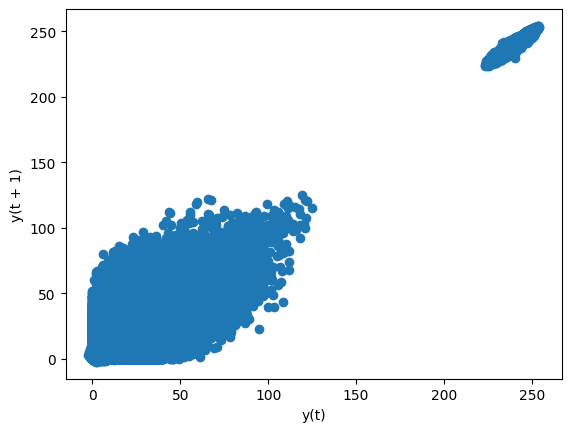

In [70]:
pd.plotting.lag_plot(df, lag=1)
plt.show()

The scatter plot shows y(t) on the x-axis and y(t+1) (the next observation) on the y-axis. There are 2 seperate groups of points: cluster 1, values between 0 and 120 representing majority of the data, which I suppose the standard behaviour (daily patterns). While cluster 2 cointains fewer points around 220 and 260 and they are very close together. 

In [71]:
y = df["y"].copy()

df_lags = pd.DataFrame({
    "y(t-3)": y.shift(3),
    "y(t-2)": y.shift(2),
    "y(t-1)": y.shift(1),
    "y(t)": y,
}).dropna()

df_lags.corr()

y(t-3)    y(t-2)    y(t-1)      y(t)
y(t-3)  1.000000  0.952737  0.907180  0.877162
y(t-2)  0.952737  1.000000  0.952738  0.907179
y(t-1)  0.907180  0.952738  1.000000  0.952737
y(t)    0.877162  0.907179  0.952737  1.000000

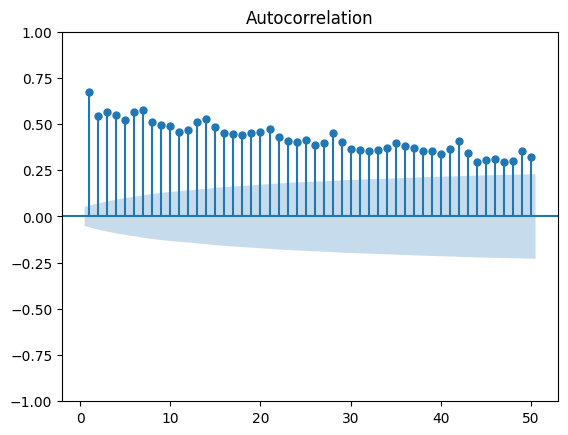

In [72]:
plot_acf(y_daily, lags=50, zero=False)
plt.show()

The autocorrelation starts at 0.70 which means that today’s consumption is highly dependent on yesterday’s value 'lag(1)'. The autocorrelation decreases gradually but remains well above zero for more than 50 lags, meaning that past values influence the future values . 

## Data pretreatment

In [73]:
df.index.name

'DateTime'

In [74]:
time_diffs = df.index.to_series().diff().dropna()
freq_counts = time_diffs.value_counts().sort_index()
print(freq_counts)

DateTime
0 days 00:01:00    2075258
Name: count, dtype: int64


As examined in the week ML2 submission, the most common time difference between consecutive measurements is 1 minute, and all the samples follow this exact 1-min-interval, which has been checked whether the continuous measurements have the same frequency, meaning I computed the time difference between consecutive timestamps. The results show that every measurement is exactly one minute apart (0 days 00:01:00), with a total count of 2,075,258 observations. Therefore, the dataset has a uniform sampling frequency, and no additional preprocessing or sampling is required. 

In [75]:
print(df.isnull().any(axis=1).sum())
print(df.isnull().sum())
print(df.index.duplicated().sum())

0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
y                        0
dtype: int64
0


I looked at the missing value pattern and confirmed that each variable had the same timestamp index to see if the data was synchronous across all variables. According to the results, no variable has any missing values, and no row has any partially missing data. Furthermore, no timestamps are repeated. This confirms that all variables are perfectly aligned and measured at the same 1-minute intervals. No additional steps like resampling, interpolation, forward filling, or timestamp alignment are necessary because the dataset is completely synchronous.

In [76]:
print(df.isnull().sum().sum())
print(df.isnull().sum())

0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
y                        0
dtype: int64


In [77]:
consecutive_missing = {}
for col in df.columns:
    is_na = df[col].isna().astype(int)
    changes = np.diff(np.where(np.concatenate(([is_na.iloc[0]],
                                               is_na.values[:-1] != is_na.values[1:],
                                               [True])))[0])[::2]
    consecutive_missing[col] = changes.max() if len(changes) > 0 else 0

consecutive_missing

{'Global_active_power': 0,
 'Global_reactive_power': 0,
 'Voltage': 0,
 'Global_intensity': 0,
 'Sub_metering_1': 0,
 'Sub_metering_2': 0,
 'Sub_metering_3': 0,
 'y': 0}

The dataset was already checked for missing values in Week ML2, but none were found.   By checking the overall number of missing entries and the number of missing values in each variable, I confirmed this once more in Week ML3. There were no missing values in any of the columns.
I identified the longest streak of missing values for every variable, and all maximum streak lengths were zero, to make sure there were no consecutive missing-value segments. This demonstrates that all timestamps in the dataset have complete observations.
While imputation is not necessary for this dataset, forward fill, backward fill, linear interpolation are common methods for filling in missing values in time-series data.

In [78]:
series = y_daily
stl = STL(series, period=7)
result = stl.fit()

residuals = result.resid
threshold = 3 * residuals.std()

outlier_mask = np.abs(residuals) > threshold
outlier_indices = series.index[outlier_mask]

print("Outliers:", outlier_mask.sum())
print(outlier_indices[:5])

Outliers: 28
DatetimeIndex(['2006-12-19', '2006-12-23', '2006-12-24', '2006-12-26',
               '2006-12-30'],
              dtype='datetime64[ns]', name='DateTime', freq=None)


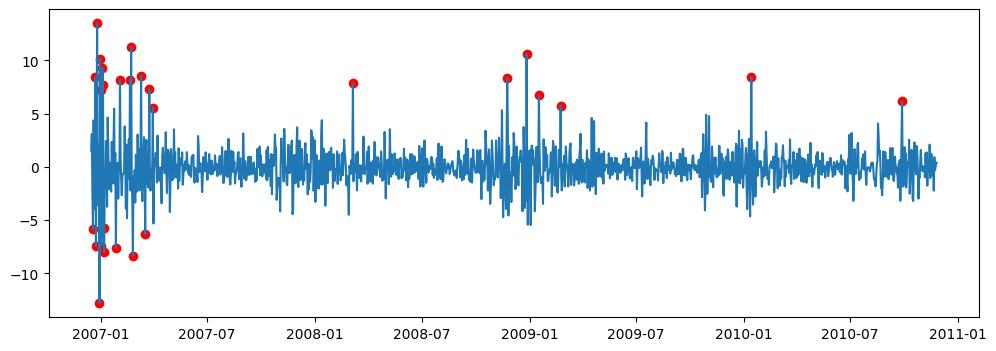

DateTime
2006-12-16    37.073064
2006-12-17    25.657407
2006-12-18    13.214190
2006-12-19    13.685150
2006-12-20    14.156111
                ...    
2010-11-22    11.753194
2010-11-23    11.355741
2010-11-24     9.562130
2010-11-25    11.999120
2010-11-26    10.568277
Freq: D, Name: y, Length: 1442, dtype: float64

In [79]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.scatter(outlier_indices, residuals[outlier_mask], color='red')
plt.show()

df_y = series.copy()
df_y[outlier_mask] = np.nan
df_y = df_y.interpolate()
df_y

In this residual plot, using a threshold of ±3 standard deviations, several outlier points are detected (illustrated in red). These were unusual deviations in the daily energy consumption not explained by the estimated trend or seasonality components. Most outliers are situated in the first year of the dataset when the signal is noisier and less stable.
These extreme values would distort the training of the model, so they were replaced with NaN and then imputed using linear interpolation. In this way, the general structure of the time series is preserved, but the influence of irregular non-repetitive fluctuations is removed.

In [80]:
df_daily_all = df.resample("D").mean()

feature_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df_mv = df_daily_all[feature_cols].copy()
df_mv["y"] = df_y.values

df_mv.head(), df_mv.shape

(            Global_active_power  Global_reactive_power     Voltage  \
 DateTime                                                             
 2006-12-16             3.053475               0.088187  236.243763   
 2006-12-17             2.354486               0.156949  240.087028   
 2006-12-18             1.530435               0.112356  241.231694   
 2006-12-19             1.157079               0.104821  241.999313   
 2006-12-20             1.545658               0.111804  242.308062   
 
             Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
 DateTime                                                                       
 2006-12-16         13.082828        0.000000        1.378788       12.439394   
 2006-12-17          9.999028        1.411806        2.907639        9.264583   
 2006-12-18          6.421667        0.738194        1.820139        9.734722   
 2006-12-19          4.926389        0.582639        5.279167        4.303472   
 2006-12-20    

## Scale Multivariate Data

In [81]:
values_mv = df_mv.values.astype(np.float32)
num_features = values_mv.shape[1]

N_total_days = len(values_mv)
N_train_days = int(N_total_days * 0.8)

scaler_mv = MinMaxScaler()

train_scaled_mv = scaler_mv.fit_transform(values_mv[:N_train_days])
test_scaled_mv  = scaler_mv.transform(values_mv[N_train_days:])

data_scaled_mv = np.vstack([train_scaled_mv, test_scaled_mv])

target_idx = df_mv.columns.get_loc("y")

num_features, target_idx

(8, 7)

## Multivariate Sequence Generator

In [82]:
def create_multivariate_dataset(data_2d, T, target_idx):
    X, Y = [], []
    for i in range(len(data_2d) - T):
        X.append(data_2d[i:i+T, :])
        Y.append(data_2d[i+T, target_idx])
    return np.array(X), np.array(Y)

## Create Training/Testing Windows

In [83]:
T_mv = 7

X_mv, Y_mv = create_multivariate_dataset(data_scaled_mv, T_mv, target_idx)

N_train_seq_mv = N_train_days - T_mv

X_train_mv = X_mv[:N_train_seq_mv]
Y_train_mv = Y_mv[:N_train_seq_mv]

X_test_mv  = X_mv[N_train_seq_mv:]
Y_test_mv  = Y_mv[N_train_seq_mv:]

X_train_mv.shape, X_test_mv.shape

((1146, 7, 8), (289, 7, 8))

In [84]:
def plot_train_test_split(df_y, N_train):
    plt.figure(figsize=(15,4))
    plt.plot(df_y.index[:N_train], df_y.values[:N_train], label="Train", c="blue")
    plt.plot(df_y.index[N_train:], df_y.values[N_train:], label="Test", c="orange", alpha=0.8)
    plt.axvline(df_y.index[N_train], c="red", linewidth=2)
    plt.title("Train/Test Split (80/20) on Daily Energy Series")
    plt.xlabel("Date")
    plt.ylabel("Energy Consumption (Wh/min)")
    plt.legend()
    plt.show()

## Build Multivariate RNN & LSTM Models

In [85]:
def build_rnn(units=64, dense_units=32, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units, activation='tanh', input_shape=(T_mv, num_features)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_lstm(units=64, dense_units=32, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=(T_mv, num_features)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

## Train RNN

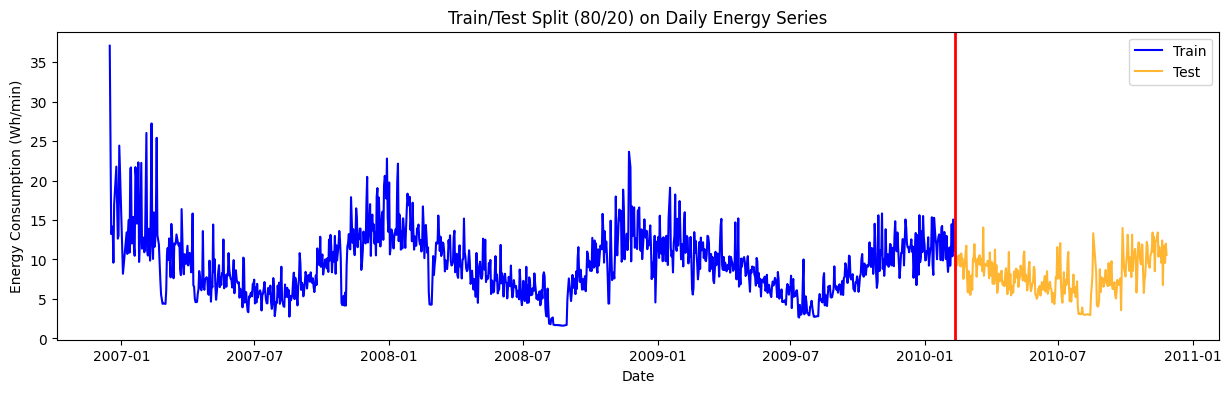

C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0105 - val_loss: 0.0050
Epoch 2/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 3/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 4/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 5/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 6/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 7/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 8/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 9/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 10/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 11/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 12/200
144/144 ━━━━━━━━━━━━━

In [86]:
plot_train_test_split(df_y, N_train_days)

model_rnn = build_rnn()

history_rnn = model_rnn.fit(
    X_train_mv, Y_train_mv,
    validation_data=(X_test_mv, Y_test_mv),
    epochs=200,
    batch_size=8,
    verbose=1
)

The plot illustrates the 80/20 train–test split applied to the daily energy consumption series. The blue segment represents the training period spanning from late 2006 to early 2010, while the orange segment represents the final 20% of the data used for testing, covering most of 2010. The vertical red line marks the exact boundary between the two sets.

## Train LSTM

In [87]:
model_lstm = build_lstm()

history_lstm = model_lstm.fit(
    X_train_mv, Y_train_mv,
    validation_data=(X_test_mv, Y_test_mv),
    epochs=200,
    batch_size=8,
    verbose=1
)

Epoch 1/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - val_loss: 0.0081
Epoch 2/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 3/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 4/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 5/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 6/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 7/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 8/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 9/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 10/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 11/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 12/200
144/144 ━━━━━━━━━━━━━━━━━━━━

## Inverse Transform for y Only

In [88]:
def inverse_transform_y(y_scaled, scaler, target_idx):
    y_scaled = y_scaled.reshape(-1, 1)
    dummy = np.zeros((len(y_scaled), scaler.n_features_in_))
    dummy[:, target_idx] = y_scaled[:, 0]
    inv = scaler.inverse_transform(dummy)
    return inv[:, target_idx]

## Predict & Plot RNN Results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


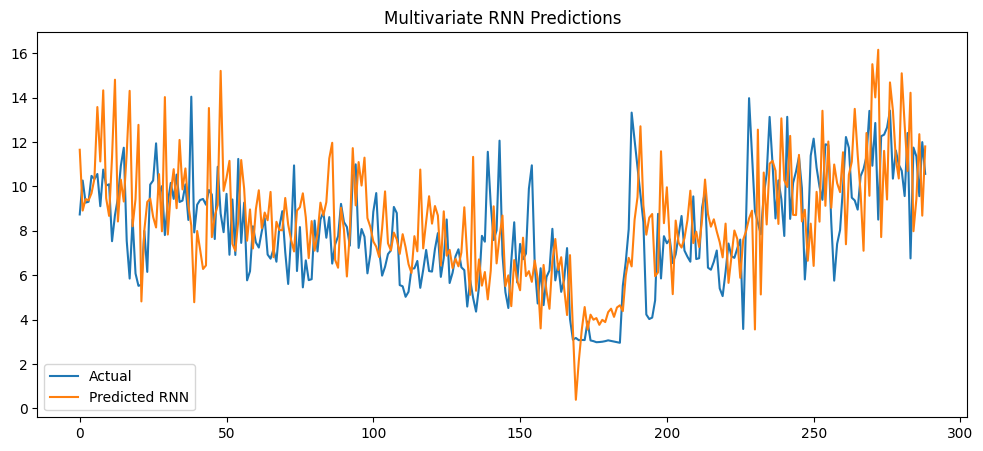

RNN MSE: 6.762241435888745


In [89]:
preds_rnn = model_rnn.predict(X_test_mv)

y_pred_rnn = inverse_transform_y(preds_rnn, scaler_mv, target_idx)
y_test_rnn = inverse_transform_y(Y_test_mv.reshape(-1,1), scaler_mv, target_idx)

plt.figure(figsize=(12,5))
plt.plot(y_test_rnn, label='Actual')
plt.plot(y_pred_rnn, label='Predicted RNN')
plt.legend()
plt.title("Multivariate RNN Predictions")
plt.show()

print("RNN MSE:", np.mean((y_test_rnn - y_pred_rnn)**2))

The multivariate RNN follows the actual energy consumption values reasonably well, capturing the overall trend and many of the short term fluctuations. Because the model uses several input variables instead of only the target series, it learns a richer representation of the system, which helps improve prediction stability. The predicted curve is slightly smoother and occasionally misses sharp spikes, but overall the multivariate model shows good alignment with the true values, indicating that additional features contribute to better forecasting performance.

## Predict & Plot LSTM Results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


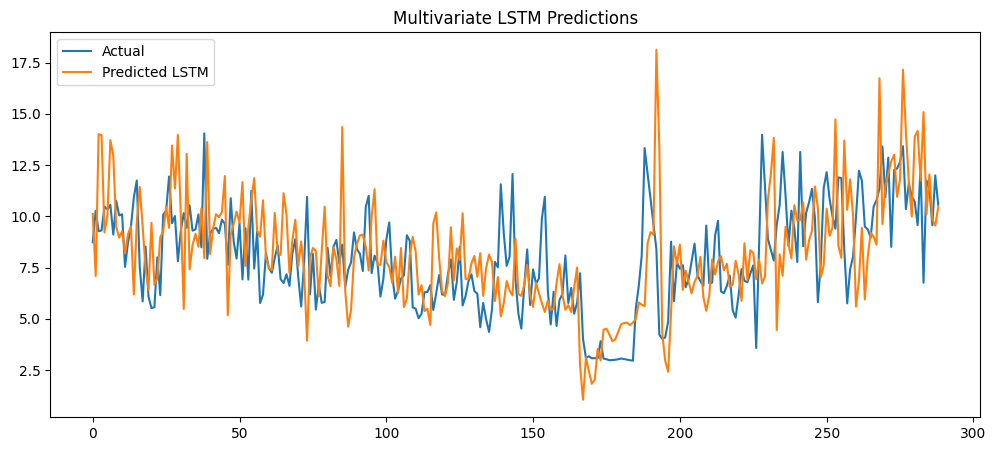

LSTM MSE: 7.369411044951493


In [90]:
preds_lstm = model_lstm.predict(X_test_mv)

y_pred_lstm = inverse_transform_y(preds_lstm, scaler_mv, target_idx)
y_test_lstm = inverse_transform_y(Y_test_mv.reshape(-1,1), scaler_mv, target_idx)

plt.figure(figsize=(12,5))
plt.plot(y_test_lstm, label='Actual')
plt.plot(y_pred_lstm, label='Predicted LSTM')
plt.legend()
plt.title("Multivariate LSTM Predictions")
plt.show()

print("LSTM MSE:", np.mean((y_test_lstm - y_pred_lstm)**2))

The multivariate LSTM model closely follows the actual energy consumption values, capturing both the overall trend and many of the short term fluctuations. By using multiple input features, the model learns more complex temporal relationships than in the univariate case, which helps improve prediction stability. The predicted curve is slightly smoother in regions with rapid changes, and a few sharp peaks are not fully captured, which is expected for LSTM models. Overall, the multivariate LSTM provides strong predictive performance and generalizes well, as reflected by its alignment with the true values and the MSE score.

## Loss Curves for RNN & LSTM

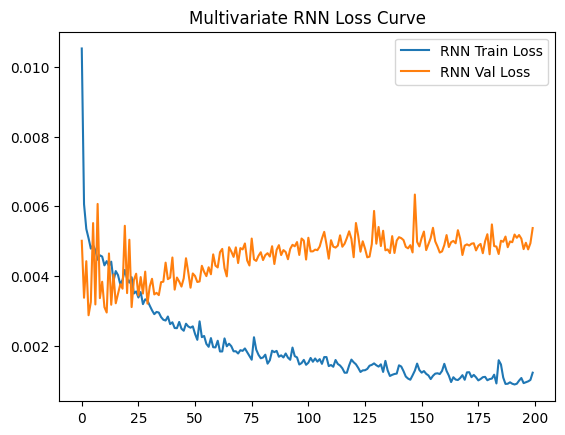

In [91]:
plt.plot(history_rnn.history['loss'], label='RNN Train Loss')
plt.plot(history_rnn.history['val_loss'], label='RNN Val Loss')
plt.legend()
plt.title("Multivariate RNN Loss Curve")
plt.show()

The multivariate RNN loss curve shows that the training loss decreases steadily and stabilizes as the model learns temporal patterns from the multifeature input data. The validation loss starts low but fluctuates more as training progresses, eventually remaining higher than the training loss. This gap indicates that while the model fits the training data well, it experiences mild overfitting on unseen data. Despite the fluctuations, the validation curve does not diverge sharply, suggesting that the model still generalizes reasonably, but could benefit from regularization techniques or earlier stopping to reduce overfitting.

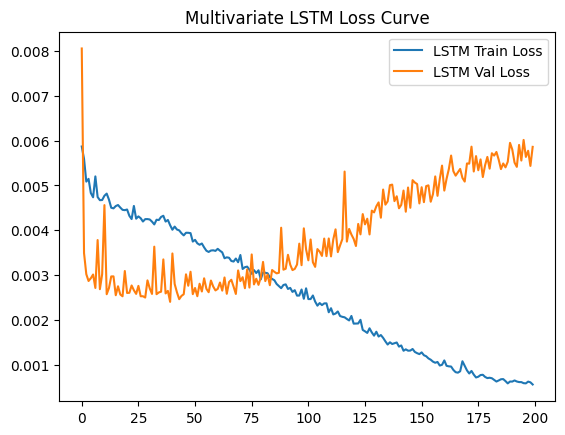

In [92]:
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.legend()
plt.title("Multivariate LSTM Loss Curve")
plt.show()

The multivariate LSTM loss curve shows a strong decrease in training loss, indicating that the model continues to fit the training data increasingly well throughout the epochs. However, the validation loss behaves differently: after an initial stable phase, it begins to rise steadily, creating a widening gap between training and validation performance. This divergence is a clear sign of overfitting—the model is learning patterns specific to the training data but is not generalizing effectively to unseen data. Although the early part of training shows reasonable generalization, the later epochs degrade validation performance, suggesting that techniques such as early stopping, dropout, or reducing model complexity would improve robustness.

## Error Histogram LSTM

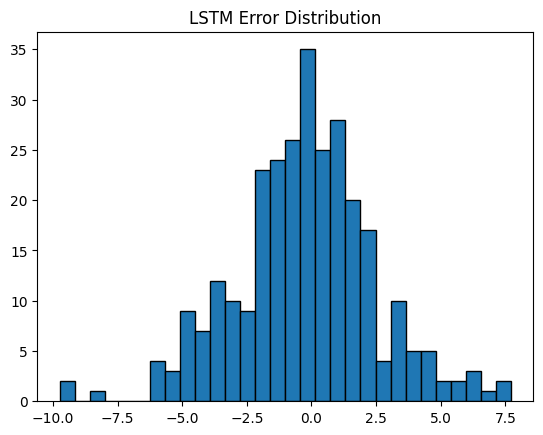

In [93]:
errors = y_test_lstm - y_pred_lstm
plt.hist(errors, bins=30, edgecolor='black')
plt.title("LSTM Error Distribution")
plt.show()

The multivariate LSTM model has an error distribution centered close to zero, which suggests that the model does not systematically overestimate or underestimate the target values. Most of the prediction errors lie within a medium range, in a roughly bell-shaped pattern, suggesting that the LSTM captures the general behavior of the series quite well. However, outliers, both on the positive and the negative side, indicate that this model struggles with the sudden spikes or abrupt drops in energy consumption. Overall, the histogram indicates reasonably good predictive accuracy with sporadic larger deviations in the more challenging parts of the time series.

## Residual Plot for LSTM

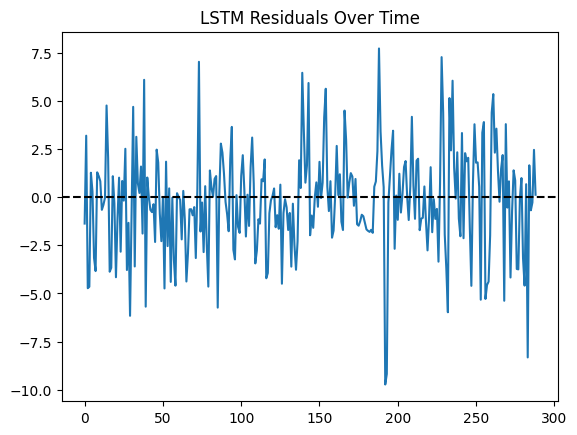

In [94]:
plt.plot(errors)
plt.axhline(0, color="black", linestyle="--")
plt.title("LSTM Residuals Over Time")
plt.show()

The residual plot shows how the prediction errors from the LSTM model evolve over time. The residuals fluctuate randomly around zero, indicating no obvious trend or systematic bias in the predictions. While some spikes appear, especially during periods of rapid changes in the true values, most residuals stay within a reasonable range. This randomness suggests that the LSTM captures the underlying pattern well, and the remaining errors are mainly due to natural variability in the data rather than model misfit.

# Improved RNN and LTSM

In [95]:
def build_rnn_mv(timesteps, num_features, units=64, dense_units=32, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units, activation='tanh', input_shape=(timesteps, num_features)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


def build_lstm_mv(timesteps, num_features, units=64, dense_units=32, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=(timesteps, num_features)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

## RNN


====== Multivariate RNN: Experiment with different T values ======

Evaluating T = 2


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RNN MSE = 3.7394


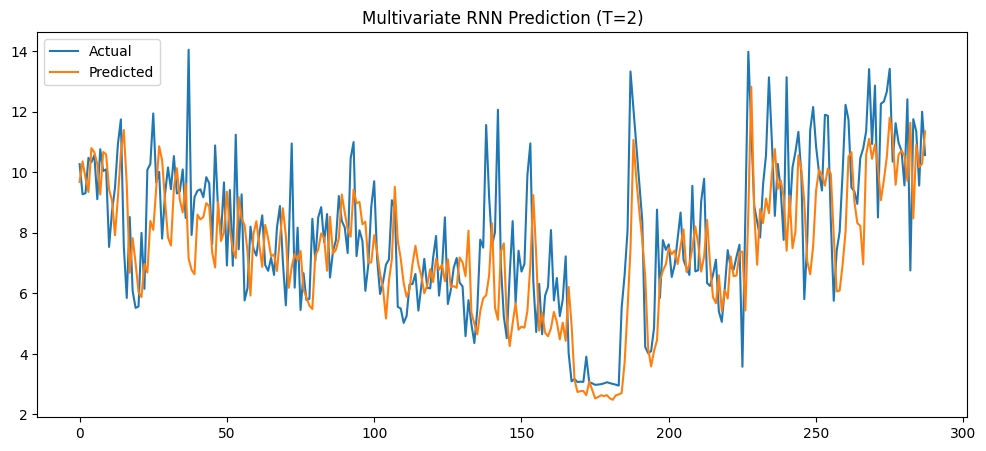


Evaluating T = 4


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RNN MSE = 3.6143


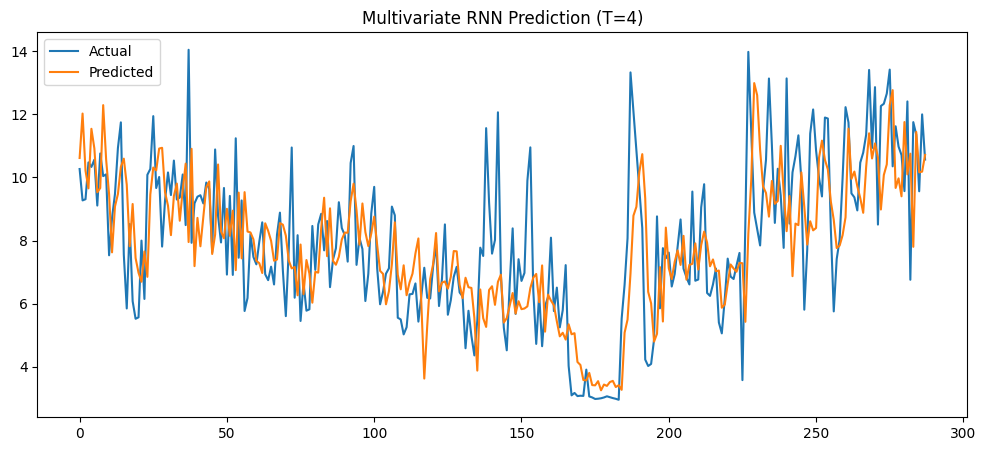


Evaluating T = 6


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RNN MSE = 4.5990


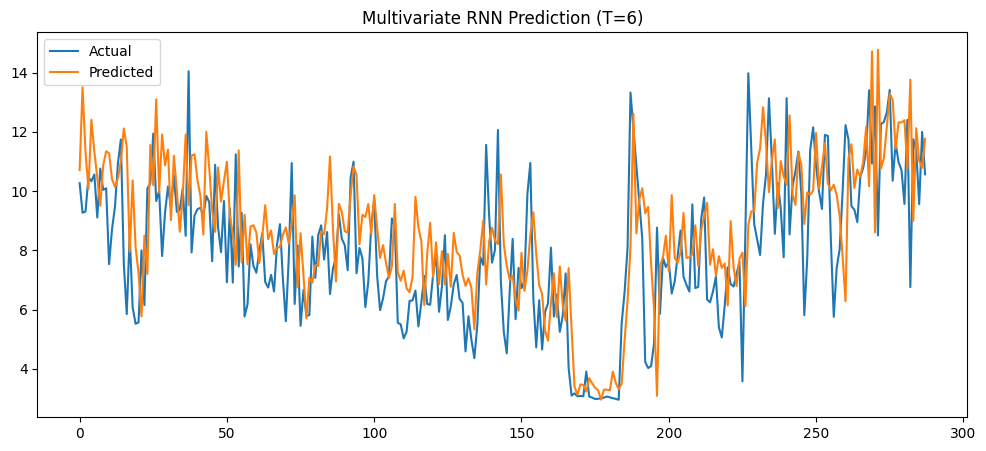


Evaluating T = 10


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RNN MSE = 4.3459


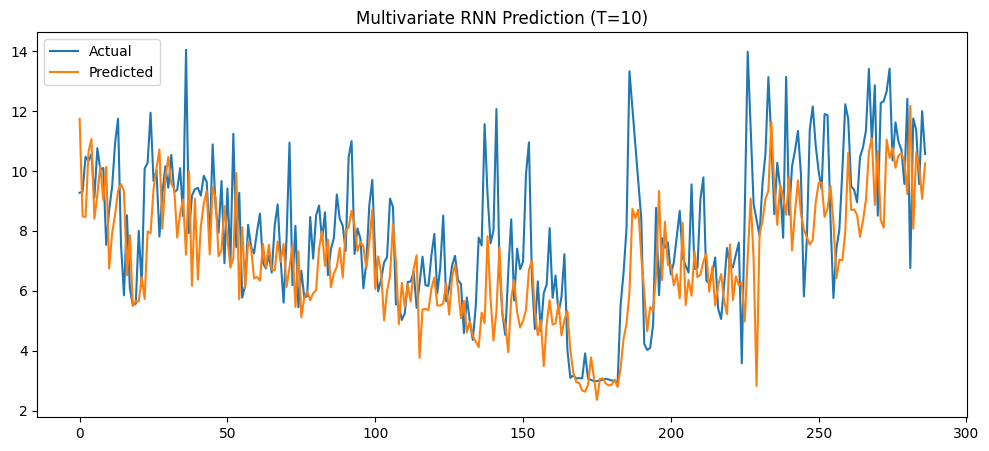


Evaluating T = 12


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RNN MSE = 3.9596


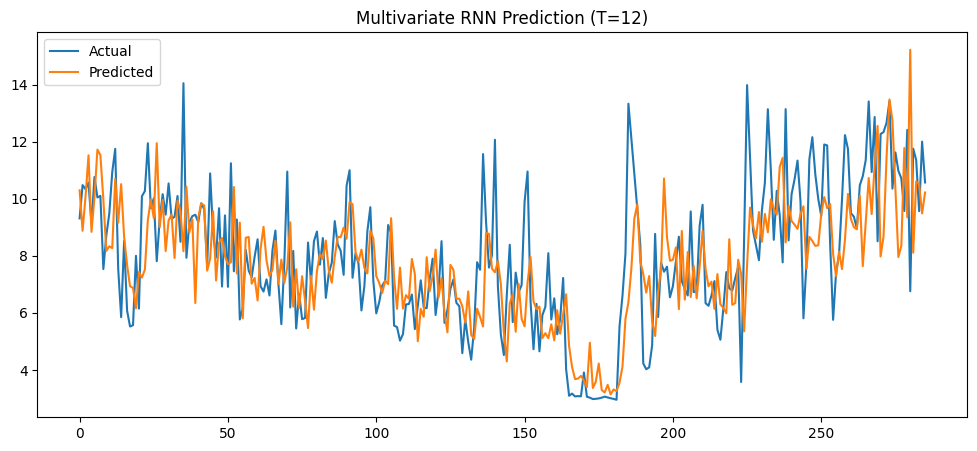

In [96]:
print("\n====== Multivariate RNN: Experiment with different T values ======")

for T_test in [2, 4, 6, 10, 12]:
    print(f"\nEvaluating T = {T_test}")

    # Create multivariate sequences
    X_mv_exp, Y_mv_exp = create_multivariate_dataset(data_scaled_mv, T_test, target_idx)

    # Train-test split
    N_exp = int(0.8 * len(X_mv_exp))
    X_train_exp = X_mv_exp[:N_exp]
    Y_train_exp = Y_mv_exp[:N_exp]
    X_test_exp  = X_mv_exp[N_exp:]
    Y_test_exp  = Y_mv_exp[N_exp:]

    # Build dynamic RNN model
    model_rnn_var = build_rnn_mv(T_test, num_features)

    # Train
    model_rnn_var.fit(
        X_train_exp, Y_train_exp,
        epochs=40,
        batch_size=32,
        verbose=0
    )

    # Predictions + inverse transform
    preds = inverse_transform_y(model_rnn_var.predict(X_test_exp), scaler_mv, target_idx)
    actual = inverse_transform_y(Y_test_exp.reshape(-1,1), scaler_mv, target_idx)

    mse = np.mean((actual - preds)**2)
    print(f"RNN MSE = {mse:.4f}")

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label="Predicted")
    plt.title(f"Multivariate RNN Prediction (T={T_test})")
    plt.legend()
    plt.show()

The multivariate RNN predictions show that the model is able to follow the overall pattern of the actual energy consumption across all tested window sizes (T = 2, 4, 6, 10, 12). When the input window is short (T=2 or T=4), the model captures the general trend but produces predictions that are slightly smoother and sometimes delayed, especially around sharp peaks. As T increases (T=6 and T=10), the predictions become more aligned with the actual values, indicating that a longer historical context improves the model’s ability to learn temporal dependencies. However, at very large T values (T=12), the predictions become too smooth and react more slowly to sudden changes, suggesting diminishing returns from adding more past observations. Overall, the multivariate RNN performs reasonably well and benefits from moderate window sizes, where it balances responsiveness with stability.


====== Multivariate RNN: Experiment with different epochs ======

Epochs = 50


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


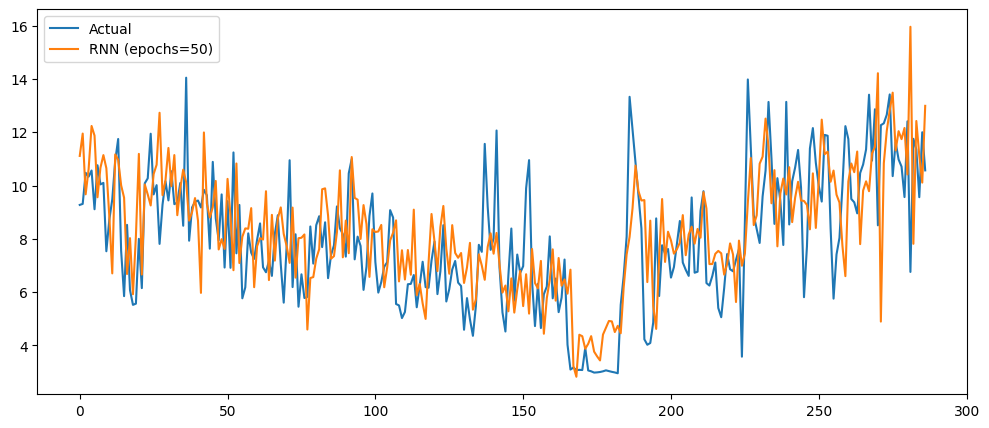


Epochs = 100


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


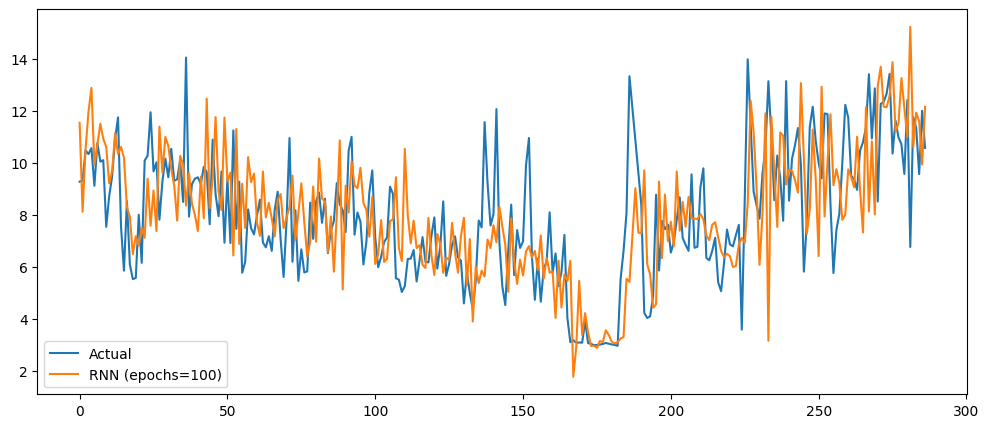


Epochs = 200


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


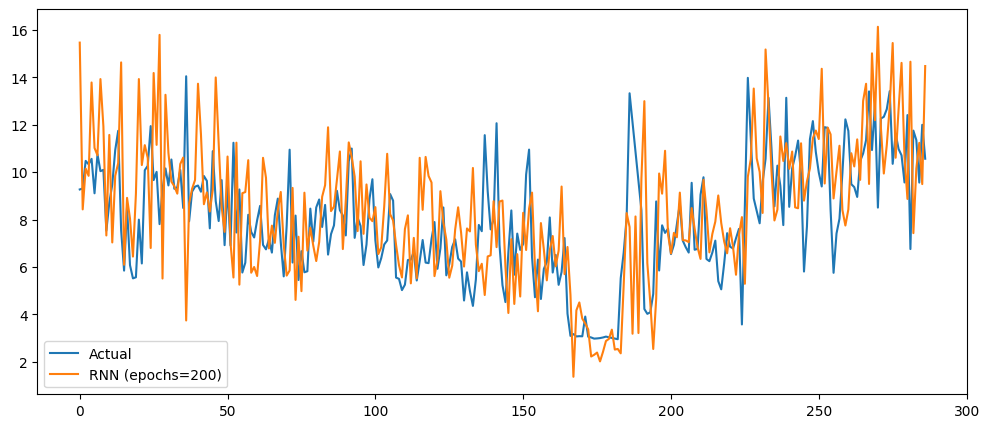


Epochs = 300


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


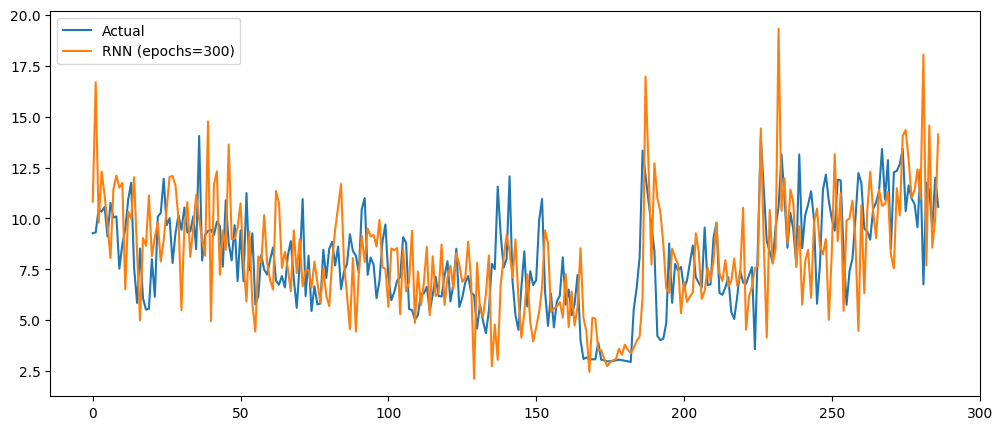

In [97]:
print("\n====== Multivariate RNN: Experiment with different epochs ======")

T_test = 7
X_mv_exp, Y_mv_exp = create_multivariate_dataset(data_scaled_mv, T_test, target_idx)

N_exp = int(0.8 * len(X_mv_exp))
X_train_exp = X_mv_exp[:N_exp]
Y_train_exp = Y_mv_exp[:N_exp]
X_test_exp  = X_mv_exp[N_exp:]
Y_test_exp  = Y_mv_exp[N_exp:]

for e in [50, 100, 200, 300]:
    print(f"\nEpochs = {e}")

    model_rnn_epochs = build_rnn_mv(T_test, num_features)

    model_rnn_epochs.fit(
        X_train_exp, Y_train_exp,
        epochs=e,
        batch_size=16,
        verbose=0
    )

    preds = inverse_transform_y(model_rnn_epochs.predict(X_test_exp), scaler_mv, target_idx)
    actual = inverse_transform_y(Y_test_exp.reshape(-1,1), scaler_mv, target_idx)

    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label=f"RNN (epochs={e})")
    plt.legend()
    plt.show()

The multivariate RNN predictions gradually improve as the number of training epochs increases. With 50 epochs, the model captures the general trend but misses several rapid fluctuations. At 100 epochs, the prediction curve aligns more closely with the actual data, showing better tracking of short-term variations. Increasing to 200 epochs further strengthens the fit, although some noise-sensitivity becomes visible. By 300 epochs, the predictions start to follow the training data very closely, but occasional overfitting appears as the model reacts too strongly to spikes. Overall, increasing epochs improves accuracy up to a point, after which the benefits diminish and overfitting begins to emerge.


====== Multivariate RNN: Experiment with Batch Size ======

Batch size = 4


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


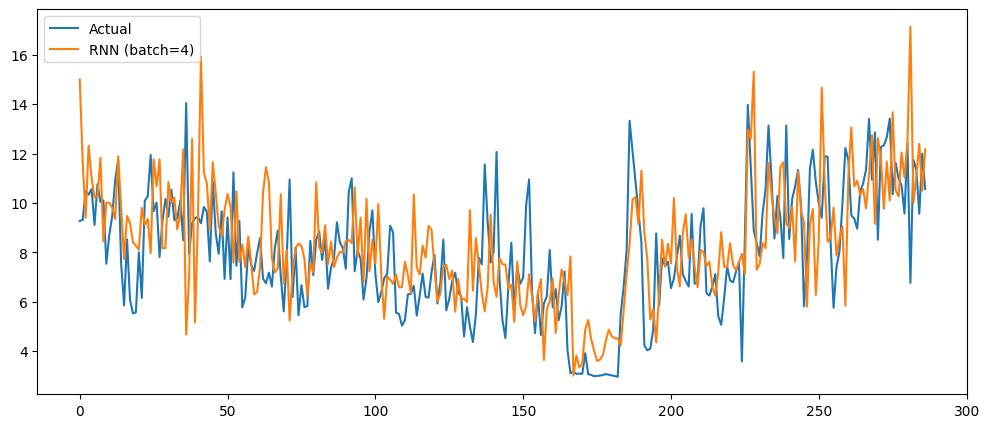


Batch size = 8


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


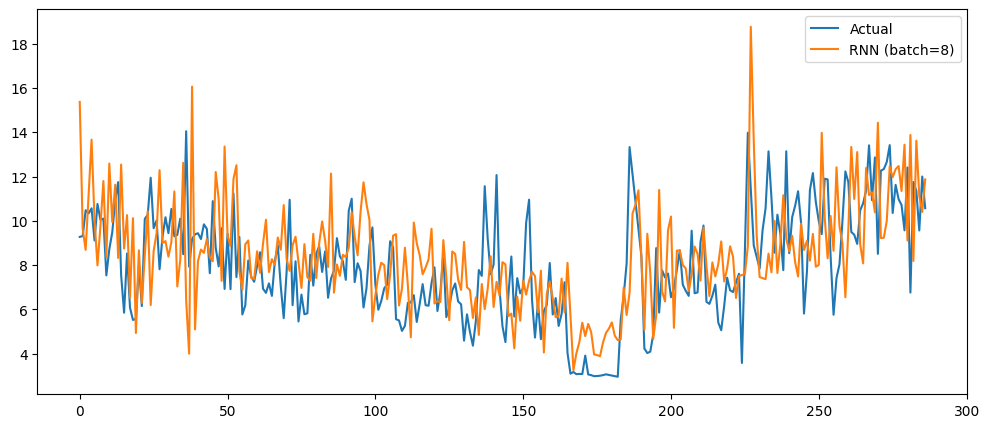


Batch size = 16


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


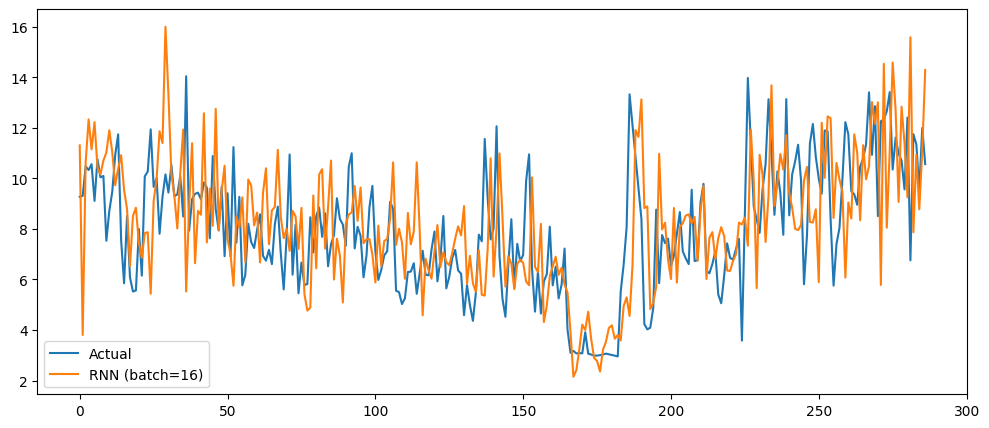


Batch size = 32


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


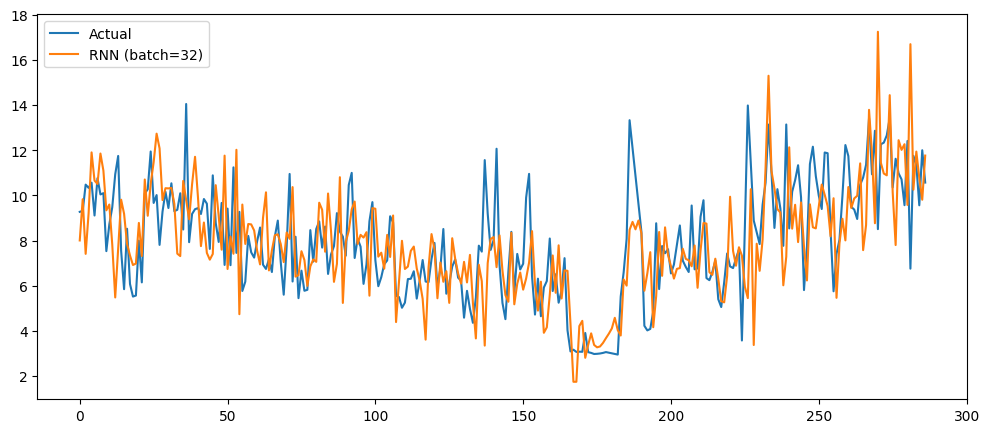


Batch size = 64


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


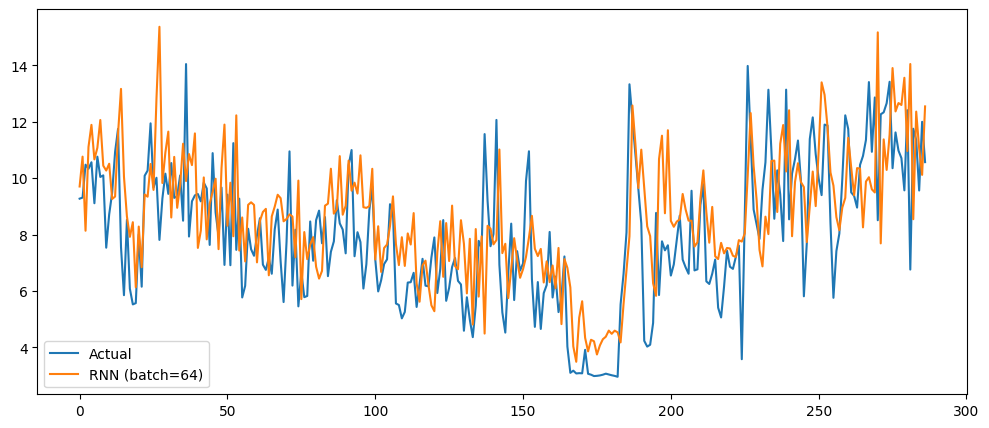

In [98]:
print("\n====== Multivariate RNN: Experiment with Batch Size ======")

batch_sizes = [4, 8, 16, 32, 64]
num_epochs = 200

T_test = 7
X_mv_exp, Y_mv_exp = create_multivariate_dataset(data_scaled_mv, T_test, target_idx)

# Train-test split (done once)
N_exp = int(0.8 * len(X_mv_exp))
X_train_exp = X_mv_exp[:N_exp]
Y_train_exp = Y_mv_exp[:N_exp]
X_test_exp  = X_mv_exp[N_exp:]
Y_test_exp  = Y_mv_exp[N_exp:]

for b in batch_sizes:
    print(f"\nBatch size = {b}")

    model_rnn_bs = build_rnn_mv(T_test, num_features)

    model_rnn_bs.fit(
        X_train_exp, Y_train_exp,
        epochs=num_epochs,
        batch_size=b,
        verbose=0
    )

    preds = inverse_transform_y(model_rnn_bs.predict(X_test_exp), scaler_mv, target_idx)
    actual = inverse_transform_y(Y_test_exp.reshape(-1,1), scaler_mv, target_idx)

    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label=f"RNN (batch={b})")
    plt.legend()
    plt.show()

The multivariate RNN batch size experiment shows that prediction quality is strongly influenced by how many samples the model processes per update. With very small batches (4 and 8), the model reacts more quickly to local fluctuations, resulting in predictions that follow the rapid ups and downs of the actual series but also appear noisier and less stable. Increasing the batch size to 16 improves smoothness while still preserving most of the short - term dynamics, producing a more balanced fit. For batch sizes of 32 and 64, the predicted curve becomes noticeably smoother and begins to miss sharper peaks and dips, indicating slower adaptation to sudden changes. Overall, moderate batch sizes (around 16) provide the best compromise between responsiveness and stability in the multivariate RNN.

## LSTM


====== Multivariate LSTM: Experiment with different T values ======

Evaluating T = 2


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
LSTM MSE (T=2): 3.2289


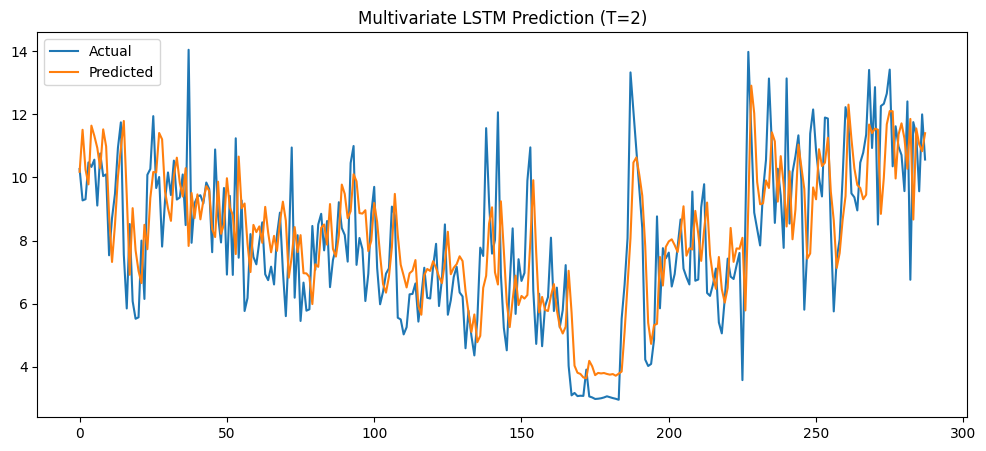


Evaluating T = 4


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM MSE (T=4): 3.4112


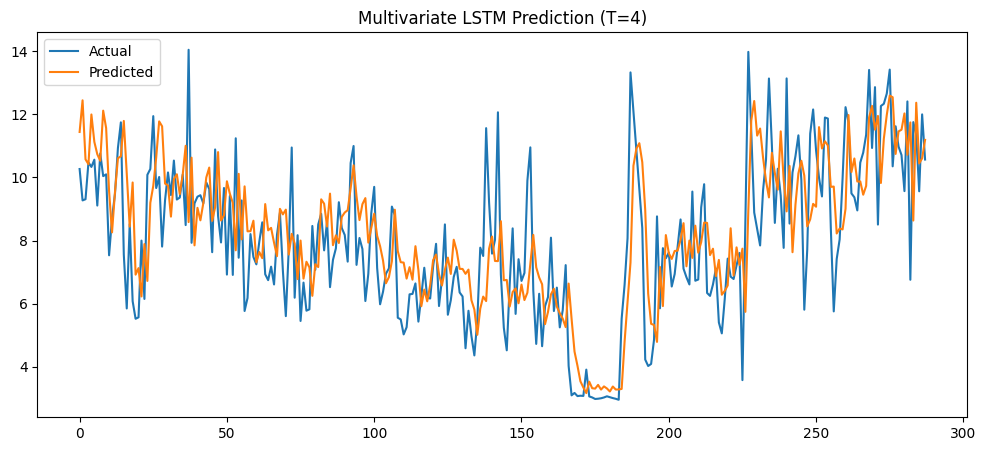


Evaluating T = 6


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM MSE (T=6): 3.2217


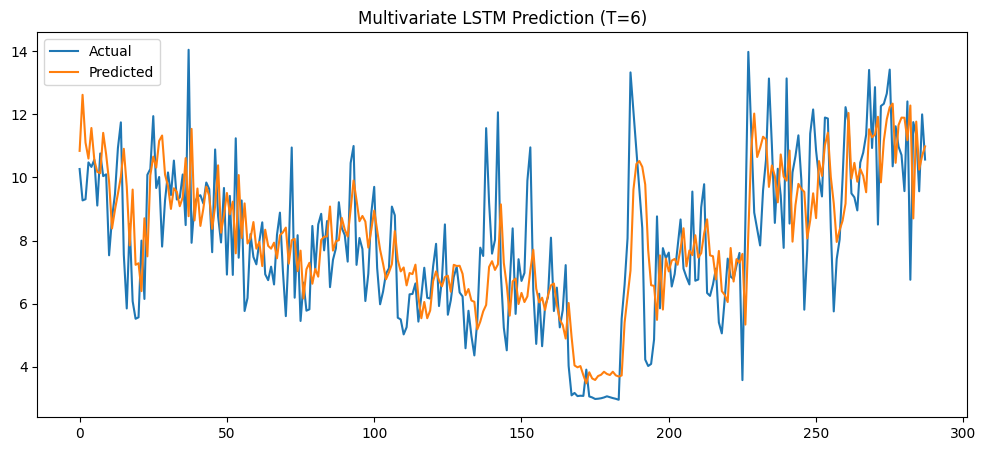


Evaluating T = 10


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM MSE (T=10): 3.1228


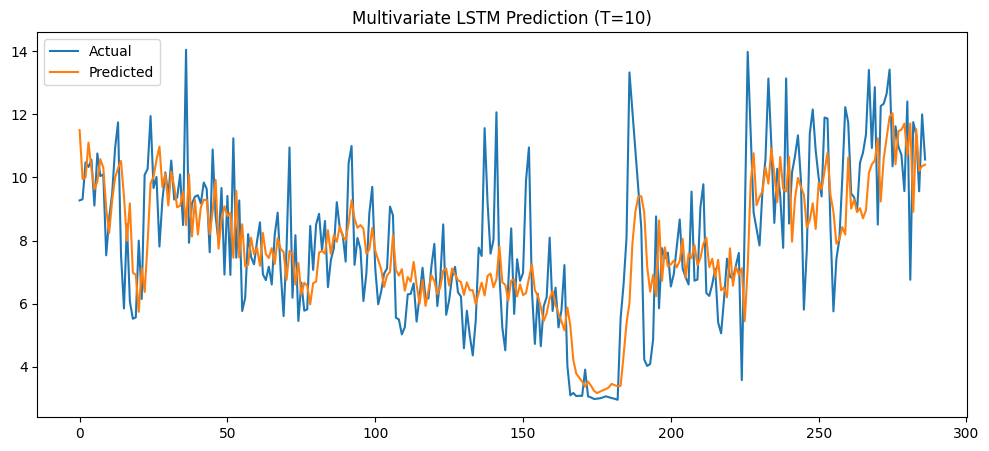


Evaluating T = 12


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM MSE (T=12): 3.2840


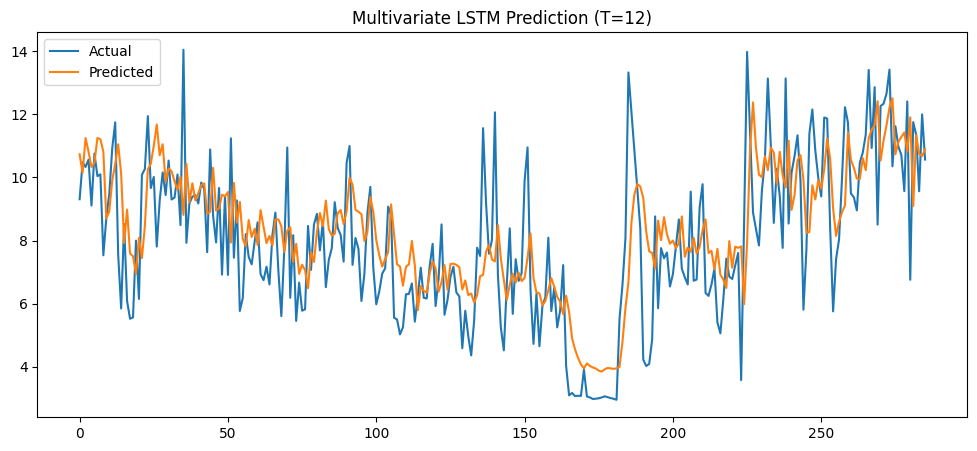

In [99]:
print("\n====== Multivariate LSTM: Experiment with different T values ======")

for T_test in [2, 4, 6, 10, 12]:
    print(f"\nEvaluating T = {T_test}")

    X_mv_exp, Y_mv_exp = create_multivariate_dataset(data_scaled_mv, T_test, target_idx)

    N_exp = int(0.8 * len(X_mv_exp))

    X_train_exp = X_mv_exp[:N_exp]
    Y_train_exp = Y_mv_exp[:N_exp]
    X_test_exp  = X_mv_exp[N_exp:]
    Y_test_exp  = Y_mv_exp[N_exp:]

    # Build models dynamically
    model_lstm = build_lstm_mv(T_test, num_features)

    # Train LSTM
    model_lstm.fit(X_train_exp, Y_train_exp, epochs=50, batch_size=32, verbose=0)

    preds = inverse_transform_y(model_lstm.predict(X_test_exp), scaler_mv, target_idx)
    actual = inverse_transform_y(Y_test_exp.reshape(-1,1), scaler_mv, target_idx)

    mse = np.mean((actual - preds)**2)

    print(f"LSTM MSE (T={T_test}): {mse:.4f}")

    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label="Predicted")
    plt.title(f"Multivariate LSTM Prediction (T={T_test})")
    plt.legend()
    plt.show()

The multivariate LSTM model shows that prediction quality varies with the chosen input window (T). For small window sizes such as T=2 and T=4, the model captures the general trend but reacts more slowly to rapid fluctuations, leading to smoother predictions. As T increases to 6 and 10, the predictions become more accurate and closely follow the actual values, indicating that the model benefits from a longer historical context when learning temporal patterns. However, with T=12, the predictions start to become overly smooth again and some sharp peaks are missed, suggesting that too long a window may make the model less responsive to short-term variations. Overall, the results indicate that moderate window sizes (T≈6–10) provide the best trade-off between stability and responsiveness for this multivariate LSTM.


====== Multivariate LSTM: Experiment with different epochs ======

Epochs = 50


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


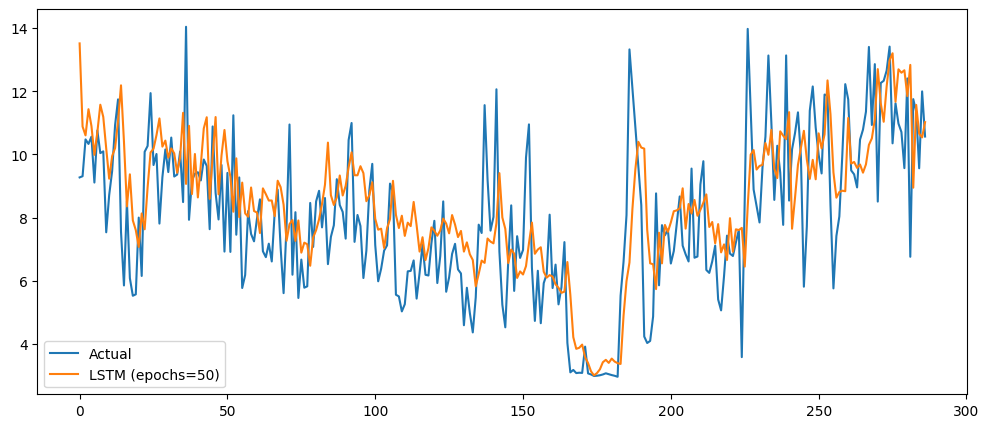


Epochs = 100


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


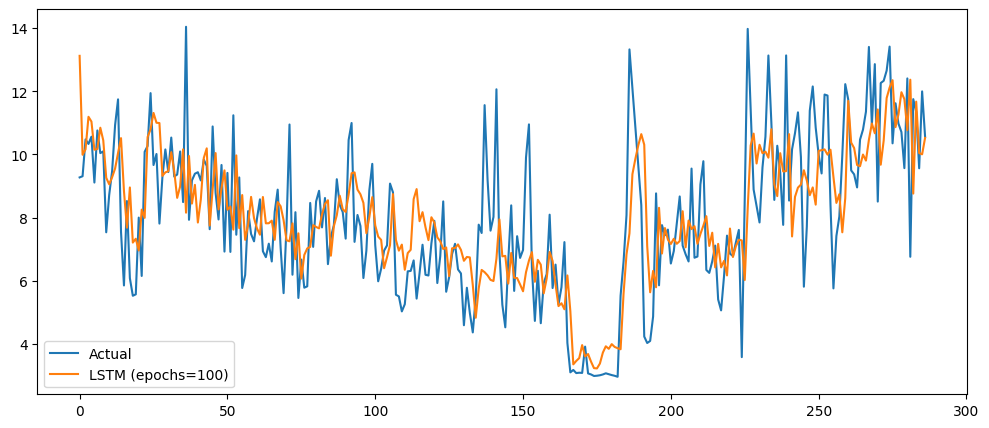


Epochs = 200


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


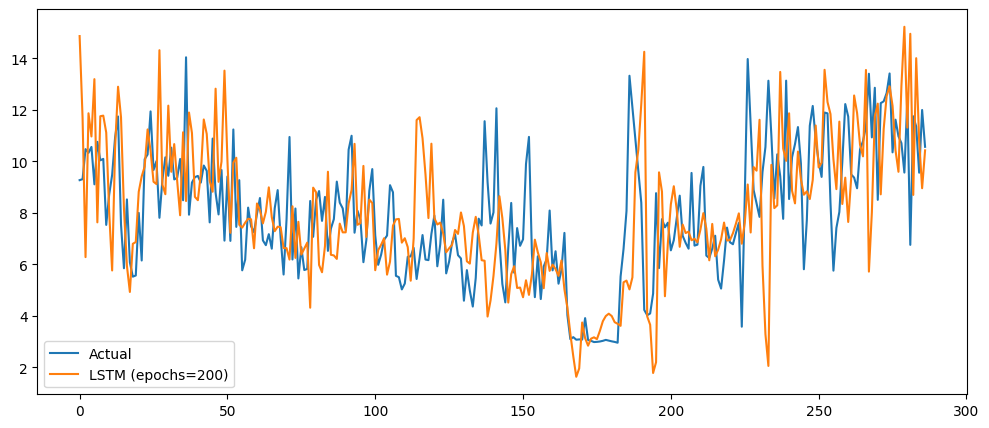


Epochs = 300


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


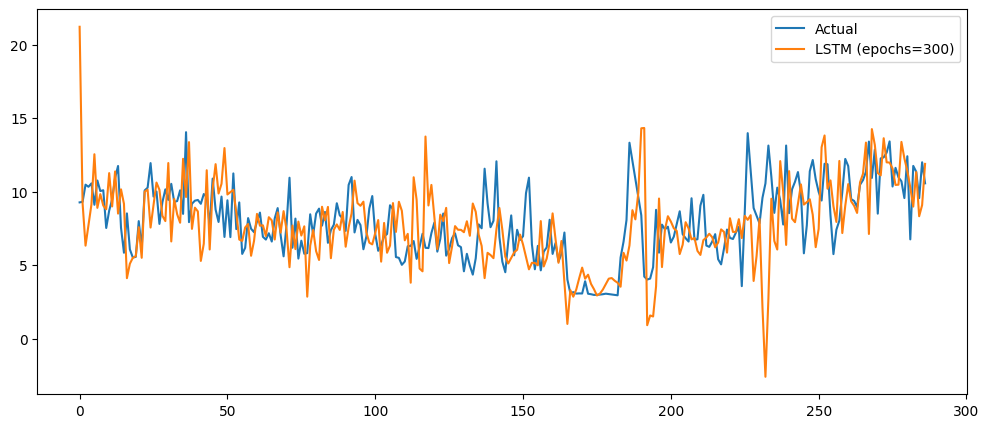

In [100]:
print("\n====== Multivariate LSTM: Experiment with different epochs ======")

T_test = 7
X_mv_exp, Y_mv_exp = create_multivariate_dataset(data_scaled_mv, T_test, target_idx)
N_exp = int(0.8 * len(X_mv_exp))

X_train_exp = X_mv_exp[:N_exp]
Y_train_exp = Y_mv_exp[:N_exp]
X_test_exp  = X_mv_exp[N_exp:]
Y_test_exp  = Y_mv_exp[N_exp:]

for e in [50, 100, 200, 300]:
    print(f"\nEpochs = {e}")

    model_lstm = build_lstm_mv(T_test, num_features)
    model_lstm.fit(X_train_exp, Y_train_exp, epochs=e, batch_size=16, verbose=0)

    preds = inverse_transform_y(model_lstm.predict(X_test_exp), scaler_mv, target_idx)
    actual = inverse_transform_y(Y_test_exp.reshape(-1,1), scaler_mv, target_idx)

    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label=f"LSTM (epochs={e})")
    plt.legend()
    plt.show()

The multivariate LSTM predictions improve in smoothness and alignment as the number of training epochs increases. With 50-100 epochs, the model already captures the overall trend but still shows small deviations during sharper fluctuations. At 200 epochs, the predicted curve follows the actual values more closely and reacts better to short-term variations. However, at 300 epochs, the model begins to overfit, shown by occasional large spikes that do not match the true series. Overall, the results indicate that the LSTM benefits from additional training up to a point, with around 100-200 epochs providing the best balance between learning and generalization.


====== Multivariate LSTM: Experiment with different batch sizes ======

Batch size = 4


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


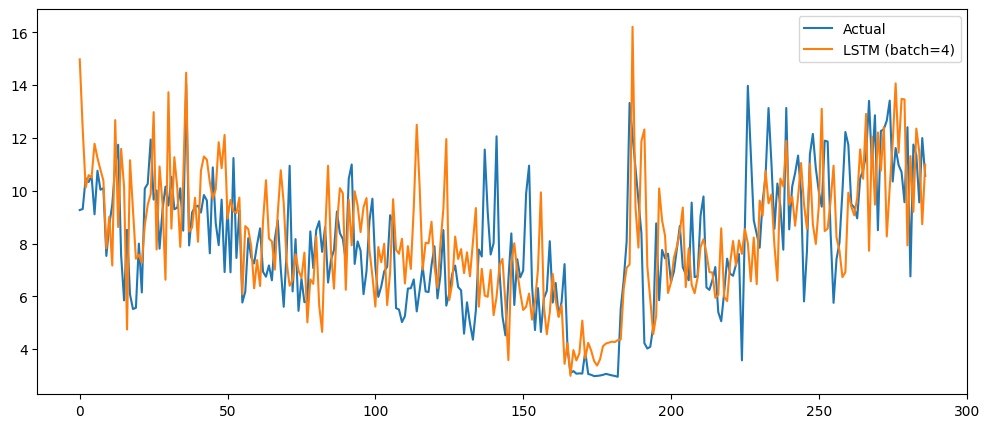


Batch size = 8


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


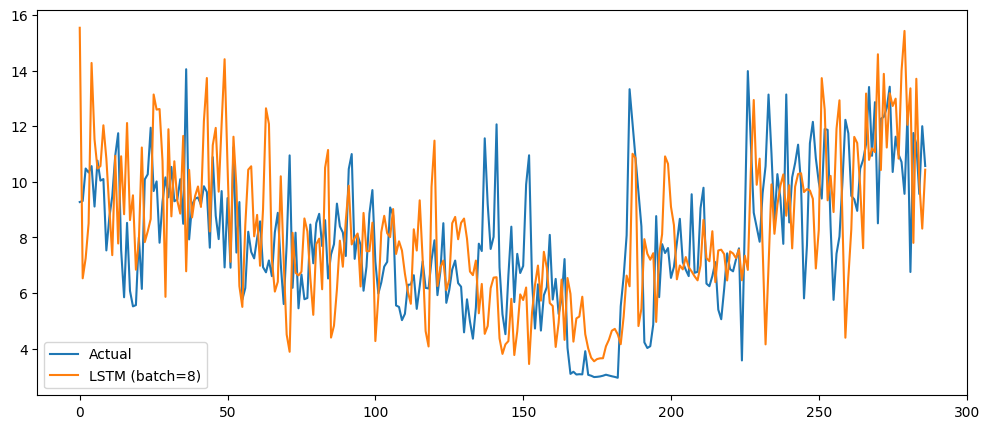


Batch size = 16


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


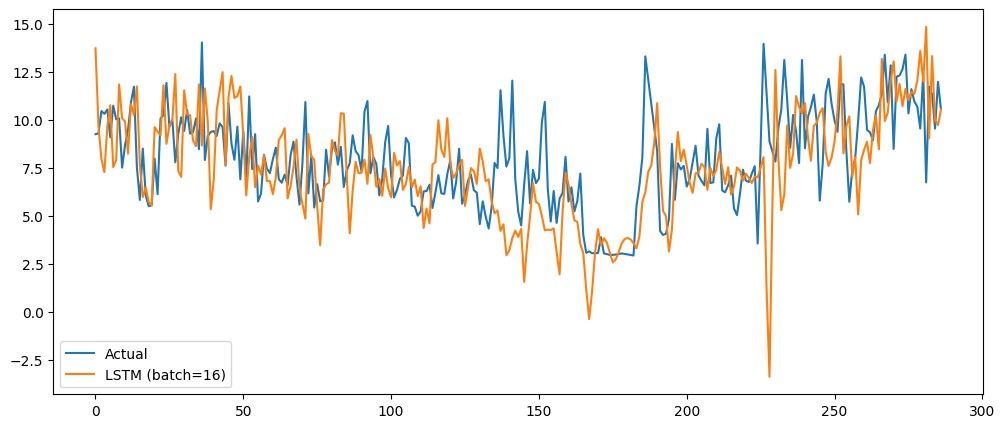


Batch size = 32


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


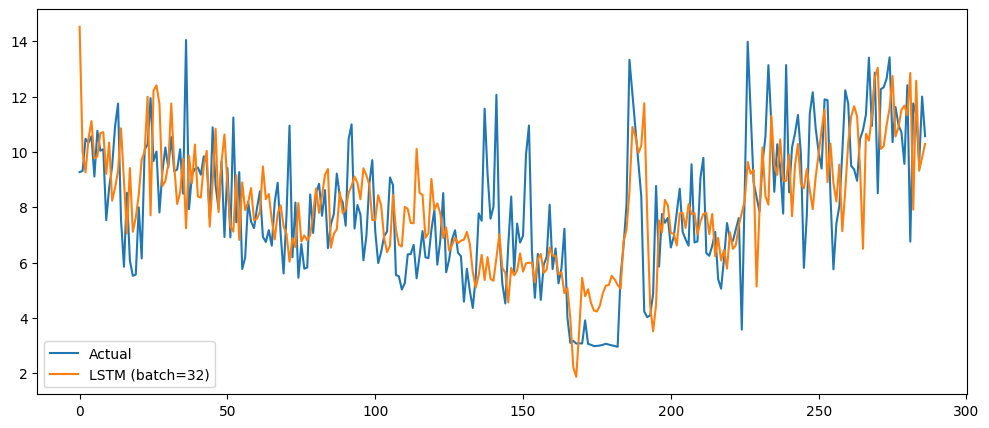


Batch size = 64


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


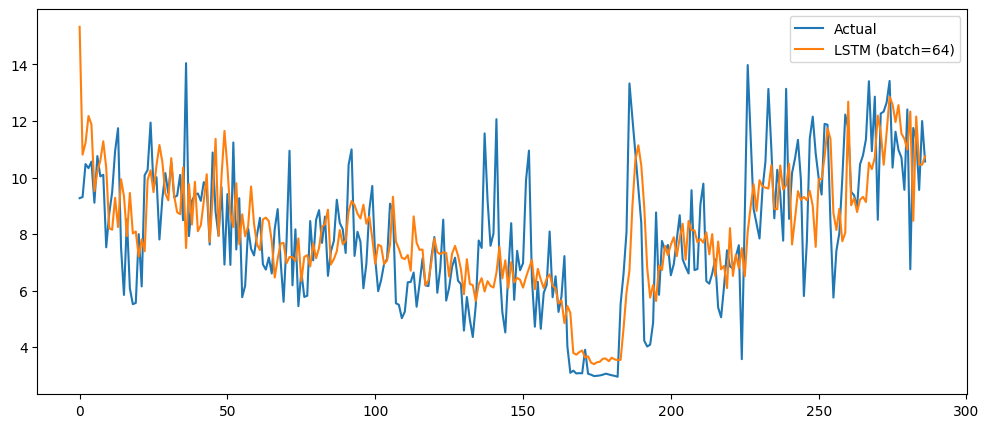

In [101]:
print("\n====== Multivariate LSTM: Experiment with different batch sizes ======")

batch_sizes = [4, 8, 16, 32, 64]
num_epochs = 200
T_test = 7

for b in batch_sizes:
    print(f"\nBatch size = {b}")

    model_lstm = build_lstm_mv(T_test, num_features)
    model_lstm.fit(X_train_exp, Y_train_exp, epochs=num_epochs, batch_size=b, verbose=0)

    preds = inverse_transform_y(model_lstm.predict(X_test_exp), scaler_mv, target_idx)
    actual = inverse_transform_y(Y_test_exp.reshape(-1,1), scaler_mv, target_idx)

    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label=f"LSTM (batch={b})")
    plt.legend()
    plt.show()

The batch size experiment shows how the multivariate LSTM model’s prediction smoothness and responsiveness change as the batch size increases. Smaller batch sizes (4 and 8) make the model more sensitive to short term fluctuations, closely following the local variations in the actual series but also producing noisier predictions. Medium batch sizes (16 and 32) give the most balanced performance predictions align well with the overall trend while still capturing many local movements, indicating good generalization. With the largest batch size (64), predictions become noticeably smoother and slightly lag behind sharp changes, suggesting that large batches reduce the model’s ability to adapt to rapid variations in the data. Overall, batch sizes between 8 and 32 provide the most stable and accurate forecasts for this multivariate LSTM setup.